# Probabilistic Principal Component Analysis
## Bayesian Statistics
 Name: Dipro Mondal
 
 

## Dependencies
First the required dependencies are loaded. For the following Probabilisty Principal Component Analysis, these libraries were used for the following notebook:
* numpy - version 1.16.4
* scikit-learn - version 0.22.1
* matplotlib - version 3.2.1
* neupy - version 0.8.2


###### In case there is an error please try installing the dependencies using these commands provided:
```
!pip install numpy==1.16.4
!pip install scikit-learn==0.22.1 
!pip install matplotlib==3.2.1
!pip install neupy==0.8.2
```



In [1]:
import numpy as np
import sklearn.datasets as ds
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import gridspec as gs
from neupy import plots


## Probabilistic Principal Component Analysis:
### Implementation 

For the Probabilistic Principal Component Analysis we need to define some functions, which would help us through the process of dimension reduction.

* A ***transform_*** function which will transform the data matrix X (which is an nxp matrix, where n is the number of samples of the data matrix and p is the number of features or dimensions) by standarding and scaling the matrix. It will return the transformed matrix along with its covaraince, and the top 'd' eigenValues and eigenVectors. Here 'd' is the number of dimensions that is kept during the dimension reduction. 


* A ***ppca_*** function which will do the principal component analysis. It retains the 'd' dimensions, or more specifically, it allows for only 'd' eigenValues (where 0<d<p) and the remaining (p-d) values add up in the variance $\mathbf{\hat{\sigma}}$. The function returns the principal components along with the posterior means and the varaince of the scrapped dimensions $\mathbf{\hat{\sigma}}$.


#### Overview
To get an overview of what the Probabilistic Principal Component Analysis or PPCA does, we first start with a datamatrix **X** which is already centred and standardized. X contains n rows each with one observation across p columns or features or dimensions. The aim of PPCA is to fit a lower dimension latent space with ***d*** dimensions to the datamatrix so that reduced datamatrix accounts for the maximum amount of variance in the data. 

This is done by projecting the matrix **X** to a reduced latent space **Z** using a projection matrix **W**. In PCA, our interest lies in estimating the principal axes term **W** and the noise $\hat{\sigma}$. Additionally, we also assume that the latent variables $z_k$ are normally distributed. (Note: the datamatrix is standardized and scaled so, mean of the data is 0 which implies that for our equations and estimates we can take the distribution means to 0 for simplicity.)

\begin{equation}
z_k  \sim N(0, I_d)
\end{equation}

where $I_d$ is the identity matrix (dxd) with diagonal elements equal to 1. The datapoints are produced via a projection

\begin{equation}
x_k|z_k \sim N(Wz_k, \sigma^2 I_p)
\end{equation}

Now, marginalizing out the latent variable, the distribution of each datapoint becomes:
\begin{equation}
x_k \sim N(0,WW^T+\sigma^2 I_p)
\end{equation}

Using Maximum Likelihood Estimation, we obtain the estimates:
\begin{equation}
\hat{W} = V_d(\Lambda_d - \sigma^2 I_d)^{1/2} 
\end{equation}

where $V_d$ are the eigenvectors corresponding to the 'd' largest eigen values $\Lambda_d$; and sigma^2 is the noise which can be estimated as the equation below. We also get a rotation matrix as a product, but it is assumed to be identity for simplicity.

The Estimate of the variance for the components:

\begin{equation}
\hat{\sigma}^2 = \frac{1}{p-d}\large{\sum}_{k=d+1}^p \lambda_k
\end{equation}

where $\lambda_k$ are the remaining eigenvalues after choosing 'd' largest ones.

The principal component can be obtained by $(V_d^T.X^T)^T$

An implementation of this is given below followed by an example with a part of reduced MNIST dataset.

#### References:


In [2]:
def transform_(X, scaleX=True):
  ## Given a matrix X, trasform will centre the matrix X (so that mean,μ = 0)
  ##    as well return the covariance, eigenvectors and eigenfunctions of X  
  ## X: 2D data matrix or ndarray, where the rows refer to the observations of 
  ##    each data point and the columns are the variables.
  ## scaleX: (Optional) boolean argument; setting it to False removes the step
  ##    of scaling the matrix. Note: scaling tyype - Min-Max Scaling

    transform_scale = MinMaxScaler()
    transform_scale.fit(X)
    
    
    means_X = np.mean(X.T,axis = 1)
    X_cent = X-means_X               ## Center the data by substracting means
    if scaleX == True:
        X_cent = transform_scale.transform(X)
    Cov = np.cov(X_cent.T)           ## Covariance of the centered data
    eVal,eVec = np.linalg.eig(Cov)   ## Eigenvalue eigenvector decomposition
    eVal = abs(eVal)
    return (X_cent, Cov, eVal, eVec) 


def ppca_(X, d, scale_=True, hintonplot=False, ax= None):
    ## Given a matrix X, the function ppca_ returns the Probabilistic Principal
    ##    Component Analysis(PPCA) for 'd' dimensions. It returns the components of 
    ##    the PPCA, the posterior means and variance for the remaining dimensions.
    ##    Optionally it also prints the hinton plot of the transformation matrix.
    ## X: 2D data matrix or ndarray; where the rows refer to the observations of 
    ##    each data point and the columns are the variables.
    ## d: int;number of components to keep. The number of components must be less
    ##    than the number of observations/dimensions of X (d<X.shape[1])
    ## hintonplot: (Optional) boolean variable; set 'True' to return the Hinton plot of
    ##    the transformation matrix W
    ## ax: (Optional)axes; setting the axes of the matplotlib figure. Use it to set the 
    ##    axis for the plot of the hinton plot. (Only useful if hintonplot=True).
    
    
    
    if (d >= X.shape[1]):
        raise ValueError("number of dimensions to keep must be less than the dimension of data")
        return
    
    X_centred, CovX, eigVal, eigVec = transform_(X,scaleX=scale_)

    ## Now for the ppca only the d largest eigenvalues are retained in eigVal_d
    ##    and the corresponding eigenvectors are stored in eigVec_d
    eigVal_d = -np.sort(-eigVal)[:d]
    eigVec_d = eigVec[:, np.argsort(-eigVal)[:d]]
  
    ## A diagonal matrix with d largest eigenvalues is constructed along with a 
    ##    matrix V_d whose columns contain the correeponding eigenvectors
    Lmd_d = np.diag(eigVal_d)  
    V_d = eigVec_d
   
    ## The variance of the remaining dimensions of the data matrix(X.shape[1] - d)
    ##    go into sigmahat
    sigmahat = np.sqrt(sum(eigVal[d:])/(X.shape[1]-d)) 
    I_d = np.eye(d)

    ## The projection matrix W is obtained by MLE as described by the equations above.
    W = V_d.dot(np.sqrt(Lmd_d - sigmahat**2 * I_d))

    Mhat = W.T.dot(W) + sigmahat**2*I_d
    
    ## The posterior means can be calculated as:
    Means = X_centred.dot(W).dot(np.linalg.inv(Mhat))
    
    ## The principal components after dimension reduction can be obtained as:
    P =V_d.T.dot(X_centred.T)
    ppca_out = P.T

    
    if hintonplot ==True:
        ax= ax or plt.gca()
        plots.hinton(W, ax = ax)
    
    return(ppca_out, Means, sigmahat)

In [3]:
def Example_Metrics(X_train, X_test, y_train, y_test, ax=None, max_iter=5000, solver='saga', multi_class='multinomial', 
                              cmap = plt.cm.Reds, show_= 'all'):
    ## X_train: The datamatrix training set (response)
    ## X_test:  The datamatrix testing set (dataset used for prediction)
    ## y_train: The labels of the training set (response)
    ## y_test:  The labels of the testing set (response variables for prediction)
    ## ax: (Optional) Setting the axes of the matplotlib figure. Use it to set the axis 
    ##    for the plot of the hinton plot.
    ## Note: Logistic regression is used for the classification task.
    ## max_iter: (Optional) The max_iter (maximum iterations for solvers to converge) is 
    ##    passed to the Logistic Regression classification paramater.
    ## solver: (Optional) The solver is the Optimizing Algorithm for Logistic Regression
    ##    (default = 'saga' - faster for large datasets). Other options:
    ##    'lbfgs', 'liblinear'(-good for smaller datasets), 'sag', 'newton-cg'
    ## multi-class: (Optional) The minimising for the loss - for 'multinomial'(default)
    ##    the multinomial loss fit across the entire probability distribution is minimized
    ##    Other options: 'ovr' (binary problem is fit for each label)
    ##    'auto' (automatically selects between 'ovr' and 'multinomial')
    ## cmap: (Optional) Sets the colourmap for the plot of the confusion matrix. See
    ##    'https://matplotlib.org/tutorials/colors/colormaps.html' for details
    ## show_: (Optional) Sets the output of the function. Options:
    ##    'all' - gives the plot of confusion matrix, the confusion matrix data and 
    ##           accuracy score 
    ##    'cm'  - gives the confusion matrix data only
    ##    'acc' - gives the accuracy score only
    ##     Otherwise only displays the plot of the confusion matrix
    
    
    logisticRegr = LogisticRegression(solver=solver, multi_class=multi_class, max_iter=max_iter)
    lR  =  logisticRegr.fit(X_train, y_train)
    predict = lR.predict(X_test)
    
    cm = confusion_matrix(y_test, predict,labels=y )
    acc_score = accuracy_score(y_test, predict)
    if show_ == 'all':
        ax = ax or plt.gca()
        disp = plot_confusion_matrix(lR, X_test, y_test,cmap=cmap, ax= ax)
        return(disp,cm,acc_score)
    elif show_ == 'cm':
        return(cm)
    elif show_ == 'acc':
        return(acc_score)

def Classification_ExamplePPCA(X,y, test_size=0.25,d = 6):
    ## Given the data matrix X and the features y, it returns the plot of confusion matrix 
    ##    for the classification problem along with a plot of the plot of the same fit using
    ##    a reduced number of dimensions 'd'. The data is split into training and test set by
    ##    the test_size vaiable.
    ## X: 2D data matrix or ndarray; where the rows refer to the observations of 
    ##    each data point and the columns are the variables.
    ## y: 1D array of the labels/classes
    ## test_size: float or int; between 0.0 and 1.0; sets the proportion of data to be used for
    ##    testing purposes. If int, represents the number of samples to be used as test samples.
    ## d: int;number of components to keep. The number of components must be less
    ##    than the number of observations/dimensions of X (d<X.shape[1])
    
    fig,axs= plt.subplots(2,2, figsize=(10,9))
    gs = axs[0, 0].get_gridspec()
    axs[0,0].remove()
    axs[1,0].remove()

    ax_big = fig.add_subplot(gs[0:, 0])

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_size, random_state= 0)
    Original_ex,_,acc_orig = Example_Metrics(X_train, X_test, y_train, y_test, ax = axs[0,1], show_ = 'all')
    pp, mean, sigmahat =ppca_(X,d, hintonplot=True, ax=ax_big)
    X_train, X_test, y_train, y_test = train_test_split(pp,y, test_size=test_size, random_state= 0)
    PPCA_ex,_, acc_ppca =Example_Metrics(X_train, X_test, y_train, y_test,ax = axs[1,1], show_ ='all')
    
    print("Accuracy with original data : ", acc_orig)
    print("Accuracy with PPCA data ",d," dimensions", acc_ppca)
    axs[0, 1].set_title('Confusion Matrix of Original dataset',pad=20)
    axs[1, 1].set_title('Confusion Matrix of PPCA transformed dataset',pad=20)
    ax_big.set_title('Hinton Plot of transformation',pad=20)
    fig.tight_layout(pad= 5)
    return(Original_ex, PPCA_ex, acc_orig, acc_ppca)

In [4]:
digits = ds.load_digits()
X = digits.data
y = digits.target

Accuracy with original data :  0.9555555555555556
Accuracy with PPCA data  2  dimensions 0.5888888888888889


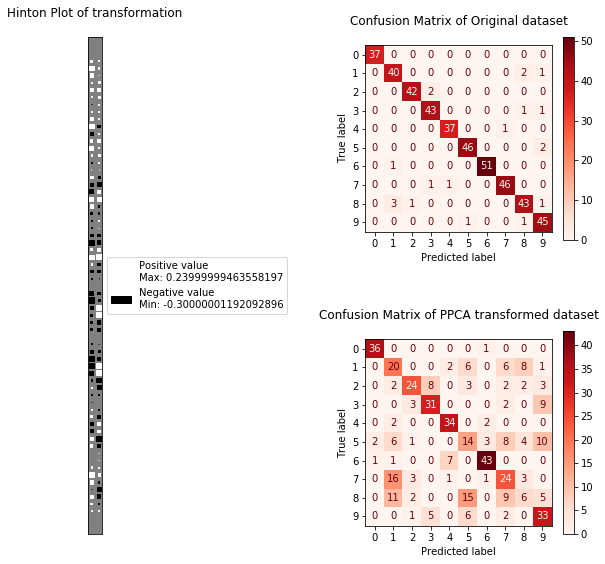

In [5]:
Principal_components, Posterior_Means, Noise = ppca_(X,2)
_,_,original_accuracy,ppca_accuracy =Classification_ExamplePPCA(X,y, d= 2)

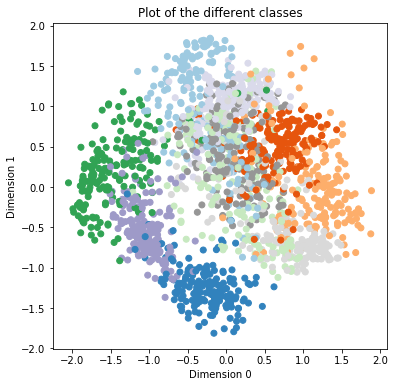

In [6]:
fig, ax = plt.subplots(1,1, figsize = (6,6))
ax.scatter(Principal_components[:,0], Principal_components[:,1], c=y, cmap=cm.tab20c)

ax.set_title('Plot of the different classes')
ax.set_xlabel('Dimension 0')
ax.set_ylabel('Dimension 1')
plt.show()

The above plot shows the different classes obtained from just 2 dimensions.

Accuracy with original data :  0.9555555555555556
Accuracy with PPCA data  8  dimensions 0.8822222222222222


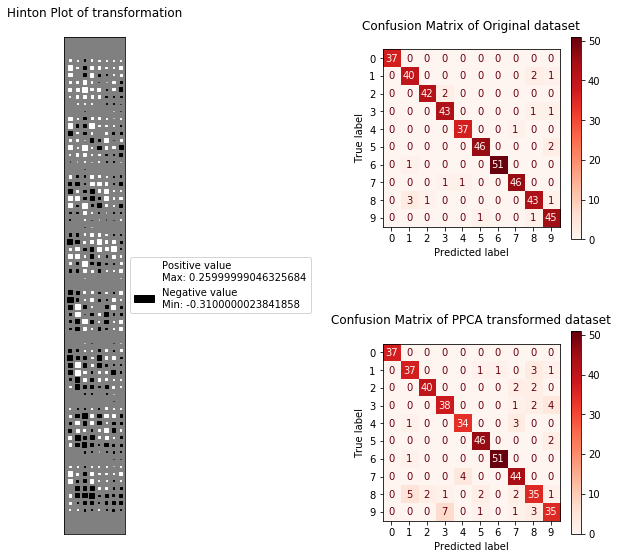

In [7]:
_,_,original_accuracy,ppca_accuracy =Classification_ExamplePPCA(X,y, d= 8)

Moving from 2 dimensions to 8, signigicantly increases accuracy. However with only 2 dimensions we can achieve an accuracy of more than 50%. Even with 8 dimensions we can get an accuracy of 88% quite close to the accuracy with the original data. To check for the minimum number of components to get an accuracy almost equal to the original data, we can look at the plot of the accuracy versus dimensions of the PPCA, as shown below.

In [8]:
sigma_list = np.zeros(25)
accuracy_list = np.zeros(25) 
dimlist = np.zeros(25)
for i in range(25):
    pp, mean, sigma_list[i] =ppca_(X,(i+1)*2)
    X_train, X_test, y_train, y_test = train_test_split(pp, y, test_size = 0.25)
    accuracy_list[i] = Example_Metrics(X_train, X_test, y_train, y_test, show_ = 'acc')
    dimlist[i] = (i+1)*2

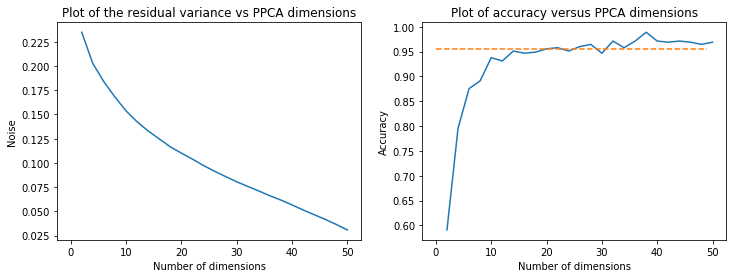

In [9]:
fig, (ax1,ax2) = plt.subplots(1,2, sharex='all',figsize=(12,4))
ax1.plot(dimlist, sigma_list)
ax2.plot(dimlist,accuracy_list)
ax2.plot(np.full(50, original_accuracy), '--')
ax1.set_title('Plot of the residual variance vs PPCA dimensions')
ax2.set_title('Plot of accuracy versus PPCA dimensions')
ax1.set_xlabel('Number of dimensions')
ax2.set_xlabel('Number of dimensions')
ax1.set_ylabel('Noise')
ax2.set_ylabel('Accuracy')
plt.show()

From the plot of the accuracy versus the number of dimension, a dimension of 21 gives approximately the same accuracy as that of the original data which is shown below.

Accuracy with original data :  0.9555555555555556
Accuracy with PPCA data  21  dimensions 0.9533333333333334


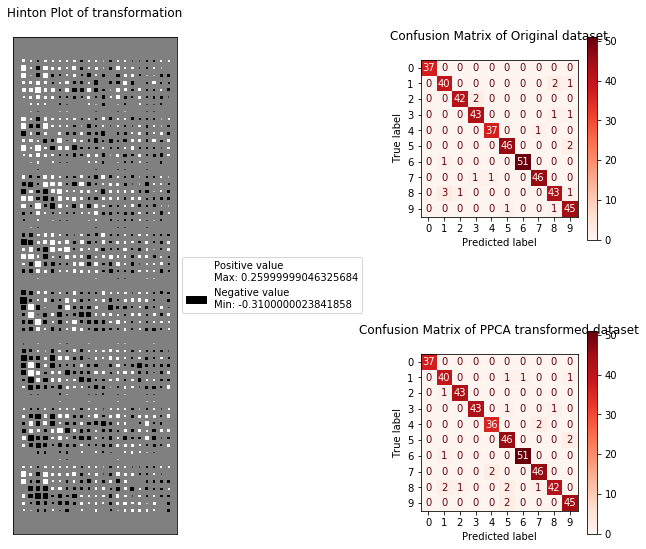

In [10]:
_,_,original_accuracy,ppca_accuracy =Classification_ExamplePPCA(X,y, d= 21)

So dimension = 21 out of 64 seems to be the best choice for the data.

## Discussion
Probabilistic PCA works and using such a dimension reduction aids in the efficiency of analysis datasets, specially high-dimensional data.

The main advantage of PPCA over PCA is not that it enables better estimation, but that it falicitates a further analysis and generative models as extensions. It also enables comparison with other probabilistic techniques.

However, though the selection of the number of dimensions though seem to be a challenge, application of Bayesian models can help determine the true dimensionality of the data.


## References
1. Oliphant TE. A guide to NumPy. Vol. 1. Trelgol Publishing USA; 2006.
2. Pedregosa, F., Varoquaux, Ga"el, Gramfort, A., Michel, V., Thirion, B., Grisel, O., … others. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12(Oct), 2825–2830.
3. Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. Computing in Science &amp; Engineering, 9(3), 90–95.
4. Tipping, M.E. and Bishop, C.M. (1999), Probabilistic Principal Component Analysis. Journal of the Royal Statistical Society: Series B (Statistical Methodology), 61: 611-622. doi:10.1111/1467-9868.00196
5. Bishop, C. M. (1999). Variational principal components. 9th International Conference on Artificial Neural Networks: ICANN ’99, 1999, 509–514. doi:10.1049/cp:19991160
6. Thomas P. Minka: Automatic Choice of Dimensionality for PCA. NIPS 2000: 598-604